<a href="https://colab.research.google.com/github/errec-sun/brain/blob/master/%D0%9F%D0%A0%D0%9E_%D0%A0%D0%B0%D0%B7%D0%B1%D0%BE%D1%80_%D0%B4%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B3%D0%BE_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D1%8F_2_%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D1%86%D0%B5%D0%BD_%D0%BD%D0%B0_%D0%BC%D0%B0%D1%88%D0%B8%D0%BD%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [0]:
# предобработка данных
from sklearn import preprocessing

# последовательная модель
from tensorflow.keras.models import Sequential
# слои
from tensorflow.keras.layers import Dense
# оптимизаторы
from tensorflow.keras.optimizers import Adadelta, Adam

# работа с csv файлами
import pandas as pd
# работа с массивами
import numpy as np
# графики
import matplotlib.pyplot as plt
%matplotlib inline 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Загрузка машин

In [0]:
# загружаем машины
cars = pd.read_csv('/content/drive/My Drive/Базы/cars_new.csv', sep=',')

In [0]:
# смотрим первые 5 машин
cars[:5]

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
0,kia,cerato,996000,2018,28000,седан,автомат,бензин,2.0,150.0
1,daewoo,nexia 1 поколение [2-й рестайлинг],140200,2012,60500,седан,механика,бензин,1.5,80.0
2,suzuki,jimny 3 поколение [рестайлинг],750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0
3,bmw,x1 18 e84 [рестайлинг],970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0
4,chevrolet,lacetti 1 поколение,205000,2007,151445,седан,механика,бензин,1.4,95.0


# Функции для предобработки

In [0]:
# создание словаря

# s - структура данных set со строковыми значениями
def create_dict(s):
  ret = {}
  # проходим по всем элементам принятого set'a
  # так как set не поддерживает индексацию, то 
  # используем enumerate, который вернёт кортеж (номер элемента, сам элемент)
  for _id, name in enumerate(s):
    # добавляем в словарь элемент {строка: число}
    ret.update({name: _id})
  return ret

In [0]:
# преобразование значения в OHE

# value - строковое значение
# d - словарь
def to_ohe(value, d):
  # создаём массив нулей по количеству элементов словаря
  arr = [0] * len(d)
  # в элемент по индексу, взятому из словаря ставим 1
  # таким образом получится рещультат на подобии [0, 0, 0, 1, 0, 0]
  arr[d[value]] = 1
  # возвращаем массив OHE
  return arr

# Изменение параметров предобработки

In [0]:
# собираем словари
marks_dict = create_dict(set(cars['mark']))
models_dict = create_dict(set(cars['model']))
bodies_dict = create_dict(set(cars['body']))
kpps_dict = create_dict(set(cars['kpp']))
fuels_dict = create_dict(set(cars['fuel']))
years_dict = create_dict(set(cars['year']))

# цены никак не меняем, переводим в numpy массив
prices = np.array(cars['price'], dtype=np.float)

# нормализуем
years = preprocessing.scale(cars['year'])
mileages = preprocessing.scale(cars['mileage'])
volumes = preprocessing.scale(cars['volume'])
powers = preprocessing.scale(cars['power'])

# не нормализованные параметры машин
years_raw = cars['year']
mileages_raw = cars['mileage']
volumes_raw = cars['volume']
powers_raw = cars['power']

In [0]:
# 80% на обучение, 20% на валидацию
val_split = 0.2
visible = -50

In [0]:
# функция для обучения сети на датамете
def train(x, y):
  # преобразуем датасеты в numpy массивы
  x = np.array(x, dtype=np.float)
  y = np.array(y, dtype=np.float)
  
  # разбиваем датасеты на проверочную и обучающую выборки
  x_train = x[:int((1.0 - val_split) * len(x))]
  y_train = y[:int((1.0 - val_split) * len(x))]
  x_val = x[int((1.0 - val_split) * len(x)):]
  y_val = y[int((1.0 - val_split) * len(x)):]
  
  # выводим статус выполнения задачи
  print('Получены обучающая и валидационная выборки')
  
  # создаём модель
  model = Sequential()
  model.add(Dense(500, activation='relu', input_shape=(x.shape[1],)))
  model.add(Dense(15, activation='relu'))
  model.add(Dense(1, activation='linear'))
  
  # компилируем модель
  model.compile(optimizer=Adam(lr=0.001), loss='mse', metrics=['mae'])
  
  # выводим статус выполнения задачи
  print('Обучение модели...')
  
  # обучаем модель
  history = model.fit(
      x_train,  # обучающая выборка
      y_train, 
      batch_size=100,  # размер пакета
      epochs=50,  # количество эпох
      validation_data=[x_val, y_val],  # валидационная выборка
      verbose=1  # выводим информацию об эпохах
  )
  return history

**Без изменений**

In [0]:
# выводим статус выполнения задачи
print('Старт')

# массивы x и y
x = []
y = []

# собираем массивы
for _id, car in enumerate(np.array(cars)):
  # добавляем в y цену автомобиля
  y.append(prices[_id])
  # x_tr - массив, содержащий параметры машины, часть в OHE, часть в нормализованном виде
  x_tr = to_ohe(car[0], marks_dict) + to_ohe(car[1], models_dict) + to_ohe(car[5], bodies_dict) + to_ohe(car[6], kpps_dict) + to_ohe(car[7], fuels_dict) + [years[_id]] + [mileages[_id]] + [volumes[_id]] + [powers[_id]]
  # добавляем x_tr в x
  x.append(x_tr)

# выводим статус выполнения задачи
print('X, Y собраны')
# запускаем обучение
history1 = train(x, y)

Старт
X, Y собраны
Получены обучающая и валидационная выборки
Обучение модели...
Train on 56095 samples, validate on 14024 samples
Epoch 1/50
56095/56095 [==============================] - 4s 71us/sample - loss: 654090670785.7285 - mean_absolute_error: 525720.6250 - val_loss: 704991207769.8118 - val_mean_absolute_error: 524324.3750
Epoch 2/50
56095/56095 [==============================] - 4s 70us/sample - loss: 628406761184.8528 - mean_absolute_error: 507397.2812 - val_loss: 656660704296.3058 - val_mean_absolute_error: 489237.1875
Epoch 3/50
56095/56095 [==============================] - 4s 69us/sample - loss: 556766966755.6139 - mean_absolute_error: 452520.9375 - val_loss: 562086902564.9469 - val_mean_absolute_error: 414913.0938
Epoch 4/50
56095/56095 [==============================] - 4s 68us/sample - loss: 448196568105.3470 - mean_absolute_error: 363780.8438 - val_loss: 444255041294.1654 - val_mean_absolute_error: 315319.9062
Epoch 5/50
56095/56095 [==============================] -

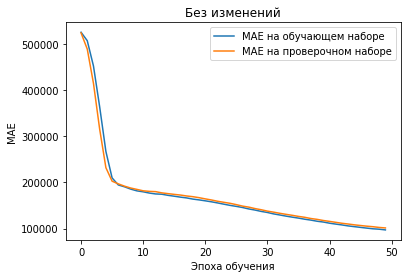

Валидационная выборка: MAE: 101334


In [0]:
# название графика
plt.title('Без изменений')
# рисуем графики MAE
plt.plot(history1.history['mean_absolute_error'][visible:], label='MAE на обучающем наборе')
plt.plot(history1.history['val_mean_absolute_error'][visible:], label='MAE на проверочном наборе')
# название шкалы X
plt.xlabel('Эпоха обучения')
# название шкалы Y
plt.ylabel('MAE')
# рисуем обозначения на графике
plt.legend()
# показываем график
plt.show()
# выводим результирующую MAE и loss на валидации
print('Валидационная выборка: MAE: {:.0f}'.format(history1.history['val_mean_absolute_error'][-1]))

**Год в OHE**

In [0]:
print('Старт')

x = []
y = []

for _id, car in enumerate(np.array(cars)):
  y.append(prices[_id])
  x_tr = to_ohe(car[0], marks_dict) + to_ohe(car[1], models_dict) + to_ohe(car[5], bodies_dict) + to_ohe(car[6], kpps_dict) + to_ohe(car[7], fuels_dict) + to_ohe(car[3], years_dict) + [mileages[_id]] + [volumes[_id]] + [powers[_id]]
  x.append(x_tr)

print('X, Y собраны')
history2 = train(x, y)

Старт
X, Y собраны
Получены обучающая и валидационная выборки
Обучение модели...
Train on 56095 samples, validate on 14024 samples
Epoch 1/50
56095/56095 [==============================] - 4s 73us/sample - loss: 650023462314.8872 - mean_absolute_error: 522347.3438 - val_loss: 687815249884.9515 - val_mean_absolute_error: 510002.5312
Epoch 2/50
56095/56095 [==============================] - 4s 70us/sample - loss: 571475065729.2208 - mean_absolute_error: 457206.9062 - val_loss: 548547844115.8608 - val_mean_absolute_error: 392911.0000
Epoch 3/50
56095/56095 [==============================] - 4s 71us/sample - loss: 403201828068.2756 - mean_absolute_error: 316833.2188 - val_loss: 377997934975.1968 - val_mean_absolute_error: 259643.6406
Epoch 4/50
56095/56095 [==============================] - 4s 71us/sample - loss: 276428567193.5681 - mean_absolute_error: 232874.5625 - val_loss: 293593739792.0639 - val_mean_absolute_error: 223281.4688
Epoch 5/50
56095/56095 [==============================] -

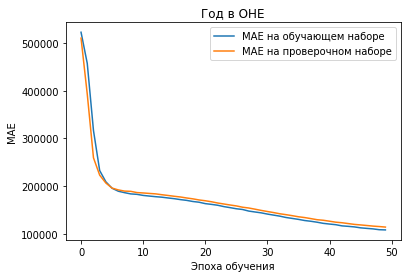

Валидационная выборка: MAE: 114575


In [0]:
plt.title('Год в OHE')
plt.plot(history2.history['mean_absolute_error'][visible:], label='MAE на обучающем наборе')
plt.plot(history2.history['val_mean_absolute_error'][visible:], label='MAE на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MAE')
plt.legend()
plt.show()
print('Валидационная выборка: MAE: {:.0f}'.format(history2.history['val_mean_absolute_error'][-1]))

**Без кузова**

In [0]:
print('Старт')

x = []
y = []

for _id, car in enumerate(np.array(cars)):
  y.append(prices[_id])
  x_tr = to_ohe(car[0], marks_dict) + to_ohe(car[1], models_dict) + to_ohe(car[6], kpps_dict) + to_ohe(car[7], fuels_dict) + [years[_id]] + [mileages[_id]] + [volumes[_id]] + [powers[_id]]
  x.append(x_tr)

print('X, Y собраны')
history3 = train(x, y)

Старт
X, Y собраны
Получены обучающая и валидационная выборки
Обучение модели...
Train on 56095 samples, validate on 14024 samples
Epoch 1/50
56095/56095 [==============================] - 4s 74us/sample - loss: 647426345838.6008 - mean_absolute_error: 521212.2812 - val_loss: 677963002073.3007 - val_mean_absolute_error: 506127.4688
Epoch 2/50
56095/56095 [==============================] - 4s 72us/sample - loss: 544289161992.9220 - mean_absolute_error: 445918.8125 - val_loss: 500504622478.9687 - val_mean_absolute_error: 371471.5625
Epoch 3/50
56095/56095 [==============================] - 4s 73us/sample - loss: 342064134614.7899 - mean_absolute_error: 280138.8125 - val_loss: 308104462608.2099 - val_mean_absolute_error: 213531.2656
Epoch 4/50
56095/56095 [==============================] - 4s 73us/sample - loss: 216024806917.7959 - mean_absolute_error: 194365.1719 - val_loss: 239542927284.0616 - val_mean_absolute_error: 194557.1562
Epoch 5/50
56095/56095 [==============================] -

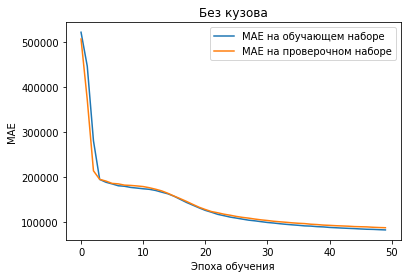

Валидационная выборка: MAE: 87125


In [0]:
plt.title('Без кузова')
plt.plot(history3.history['mean_absolute_error'][visible:], label='MAE на обучающем наборе')
plt.plot(history3.history['val_mean_absolute_error'][visible:], label='MAE на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MAE')
plt.legend()
plt.show()
print('Валидационная выборка: MAE: {:.0f}'.format(history3.history['val_mean_absolute_error'][-1]))

**Без кпп**

In [0]:
print('Старт')

x = []
y = []

for _id, car in enumerate(np.array(cars)):
  y.append(prices[_id])
  x_tr = to_ohe(car[0], marks_dict) + to_ohe(car[1], models_dict) + to_ohe(car[5], bodies_dict) + to_ohe(car[7], fuels_dict) + [years[_id]] + [mileages[_id]] + [volumes[_id]] + [powers[_id]]
  x.append(x_tr)

print('X, Y собраны')
history4 = train(x, y)

Старт
X, Y собраны
Получены обучающая и валидационная выборки
Обучение модели...
Train on 56095 samples, validate on 14024 samples
Epoch 1/50
56095/56095 [==============================] - 4s 72us/sample - loss: 649526701572.8832 - mean_absolute_error: 522779.0938 - val_loss: 686129041536.5111 - val_mean_absolute_error: 511944.9375
Epoch 2/50
56095/56095 [==============================] - 4s 69us/sample - loss: 567171420744.5170 - mean_absolute_error: 464010.6562 - val_loss: 539158029339.4547 - val_mean_absolute_error: 403235.0000
Epoch 3/50
56095/56095 [==============================] - 4s 70us/sample - loss: 385487789756.5259 - mean_absolute_error: 317842.8438 - val_loss: 348042904627.9886 - val_mean_absolute_error: 241980.9688
Epoch 4/50
56095/56095 [==============================] - 4s 70us/sample - loss: 241224909092.0760 - mean_absolute_error: 205146.8750 - val_loss: 255045201782.7267 - val_mean_absolute_error: 196342.4531
Epoch 5/50
56095/56095 [==============================] -

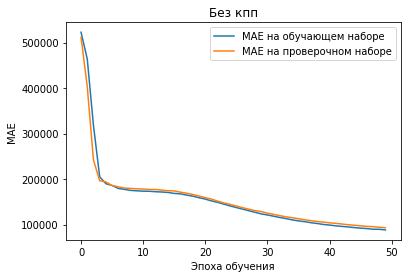

Валидационная выборка: MAE: 93192


In [0]:
plt.title('Без кпп')
plt.plot(history4.history['mean_absolute_error'][visible:], label='MAE на обучающем наборе')
plt.plot(history4.history['val_mean_absolute_error'][visible:], label='MAE на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MAE')
plt.legend()
plt.show()
print('Валидационная выборка: MAE: {:.0f}'.format(history4.history['val_mean_absolute_error'][-1]))

**Без топлива**

In [0]:
print('Старт')

x = []
y = []

for _id, car in enumerate(np.array(cars)):
  y.append(prices[_id])
  x_tr = to_ohe(car[0], marks_dict) + to_ohe(car[1], models_dict) + to_ohe(car[5], bodies_dict) + to_ohe(car[6], kpps_dict) + [years[_id]] + [mileages[_id]] + [volumes[_id]] + [powers[_id]]
  x.append(x_tr)

print('X, Y собраны')
history5 = train(x, y)

Старт
X, Y собраны
Получены обучающая и валидационная выборки
Обучение модели...
Train on 56095 samples, validate on 14024 samples
Epoch 1/50
56095/56095 [==============================] - 4s 75us/sample - loss: 647309632800.1512 - mean_absolute_error: 521167.7188 - val_loss: 677198586678.4712 - val_mean_absolute_error: 505721.1250
Epoch 2/50
56095/56095 [==============================] - 4s 72us/sample - loss: 540941527837.5499 - mean_absolute_error: 444202.3125 - val_loss: 494594820188.2944 - val_mean_absolute_error: 367352.5938
Epoch 3/50
56095/56095 [==============================] - 4s 72us/sample - loss: 335529388609.0326 - mean_absolute_error: 276392.0625 - val_loss: 302685326477.9464 - val_mean_absolute_error: 210874.1094
Epoch 4/50
56095/56095 [==============================] - 4s 73us/sample - loss: 213228916355.2060 - mean_absolute_error: 192880.3438 - val_loss: 238328907431.3565 - val_mean_absolute_error: 192854.4531
Epoch 5/50
56095/56095 [==============================] -

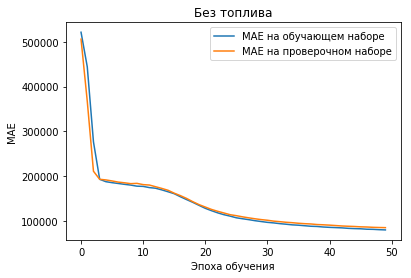

Валидационная выборка: MAE: 84933


In [0]:
plt.title('Без топлива')
plt.plot(history5.history['mean_absolute_error'][visible:], label='MAE на обучающем наборе')
plt.plot(history5.history['val_mean_absolute_error'][visible:], label='MAE на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MAE')
plt.legend()
plt.show()
print('Валидационная выборка: MAE: {:.0f}'.format(history5.history['val_mean_absolute_error'][-1]))

**Без года**

In [0]:
print('Старт')

x = []
y = []

for _id, car in enumerate(np.array(cars)):
  y.append(prices[_id])
  x_tr = to_ohe(car[0], marks_dict) + to_ohe(car[1], models_dict) + to_ohe(car[5], bodies_dict) + to_ohe(car[6], kpps_dict) + to_ohe(car[7], fuels_dict) + [mileages[_id]] + [volumes[_id]] + [powers[_id]]
  x.append(x_tr)

print('X, Y собраны')
history6 = train(x, y)

Старт
X, Y собраны
Получены обучающая и валидационная выборки
Обучение модели...
Train on 56095 samples, validate on 14024 samples
Epoch 1/50
56095/56095 [==============================] - 4s 78us/sample - loss: 650079468942.9575 - mean_absolute_error: 522557.0625 - val_loss: 689324327902.7040 - val_mean_absolute_error: 511722.8750
Epoch 2/50
56095/56095 [==============================] - 4s 73us/sample - loss: 579091340378.0872 - mean_absolute_error: 465681.0000 - val_loss: 563711347813.0565 - val_mean_absolute_error: 409069.2500
Epoch 3/50
56095/56095 [==============================] - 4s 73us/sample - loss: 421734910967.8766 - mean_absolute_error: 335528.5625 - val_loss: 395439386810.9254 - val_mean_absolute_error: 275094.1250
Epoch 4/50
56095/56095 [==============================] - 4s 72us/sample - loss: 289449452508.6771 - mean_absolute_error: 243419.7188 - val_loss: 304084868143.3154 - val_mean_absolute_error: 232383.8125
Epoch 5/50
56095/56095 [==============================] -

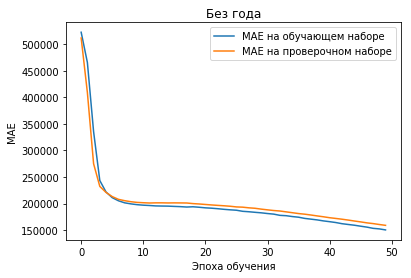

Валидационная выборка: MAE: 159081


In [0]:
plt.title('Без года')
plt.plot(history6.history['mean_absolute_error'][visible:], label='MAE на обучающем наборе')
plt.plot(history6.history['val_mean_absolute_error'][visible:], label='MAE на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MAE')
plt.legend()
plt.show()
print('Валидационная выборка: MAE: {:.0f}'.format(history6.history['val_mean_absolute_error'][-1]))

**Без пробега**

In [0]:
print('Старт')

x = []
y = []

for _id, car in enumerate(np.array(cars)):
  y.append(prices[_id])
  x_tr = to_ohe(car[0], marks_dict) + to_ohe(car[1], models_dict) + to_ohe(car[5], bodies_dict) + to_ohe(car[6], kpps_dict) + to_ohe(car[7], fuels_dict) + [years[_id]] + [volumes[_id]] + [powers[_id]]
  x.append(x_tr)

print('X, Y собраны')
history7 = train(x, y)

Старт
X, Y собраны
Получены обучающая и валидационная выборки
Обучение модели...
Train on 56095 samples, validate on 14024 samples
Epoch 1/50
56095/56095 [==============================] - 4s 76us/sample - loss: 652492076784.9170 - mean_absolute_error: 524507.4375 - val_loss: 698215037662.8500 - val_mean_absolute_error: 518937.2500
Epoch 2/50
56095/56095 [==============================] - 4s 73us/sample - loss: 604161270734.8035 - mean_absolute_error: 486852.4062 - val_loss: 607553112763.8015 - val_mean_absolute_error: 446559.9062
Epoch 3/50
56095/56095 [==============================] - 4s 72us/sample - loss: 477841354887.4502 - mean_absolute_error: 380171.1250 - val_loss: 456388186140.0388 - val_mean_absolute_error: 316318.5938
Epoch 4/50
56095/56095 [==============================] - 4s 73us/sample - loss: 336130845176.0135 - mean_absolute_error: 262170.9375 - val_loss: 335558411012.2350 - val_mean_absolute_error: 229361.8281
Epoch 5/50
56095/56095 [==============================] -

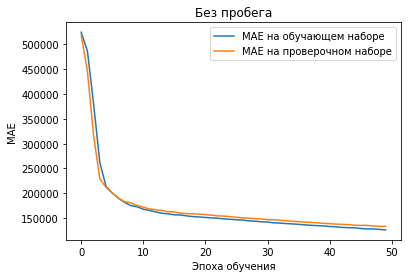

Валидационная выборка: MAE: 133325


In [0]:
plt.title('Без пробега')
plt.plot(history7.history['mean_absolute_error'][visible:], label='MAE на обучающем наборе')
plt.plot(history7.history['val_mean_absolute_error'][visible:], label='MAE на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MAE')
plt.legend()
plt.show()
print('Валидационная выборка: MAE: {:.0f}'.format(history7.history['val_mean_absolute_error'][-1]))

**Без объёма движка**

In [0]:
print('Старт')

x = []
y = []

for _id, car in enumerate(np.array(cars)):
  y.append(prices[_id])
  x_tr = to_ohe(car[0], marks_dict) + to_ohe(car[1], models_dict) + to_ohe(car[5], bodies_dict) + to_ohe(car[6], kpps_dict) + to_ohe(car[7], fuels_dict) + [years[_id]] + [mileages[_id]] + [powers[_id]]
  x.append(x_tr)

print('X, Y собраны')
history8 = train(x, y)

Старт
X, Y собраны
Получены обучающая и валидационная выборки
Обучение модели...
Train on 56095 samples, validate on 14024 samples
Epoch 1/50
56095/56095 [==============================] - 4s 79us/sample - loss: 650416182921.9602 - mean_absolute_error: 522757.5000 - val_loss: 688825206773.4855 - val_mean_absolute_error: 511732.2188
Epoch 2/50
56095/56095 [==============================] - 4s 73us/sample - loss: 573445365142.9896 - mean_absolute_error: 461914.8438 - val_loss: 551222991003.3816 - val_mean_absolute_error: 399503.1562
Epoch 3/50
56095/56095 [==============================] - 4s 72us/sample - loss: 405762825560.1933 - mean_absolute_error: 317175.7812 - val_loss: 376450734992.4290 - val_mean_absolute_error: 248951.0625
Epoch 4/50
56095/56095 [==============================] - 4s 74us/sample - loss: 272690077815.0209 - mean_absolute_error: 219025.3438 - val_loss: 284422237622.1061 - val_mean_absolute_error: 209425.0625
Epoch 5/50
56095/56095 [==============================] -

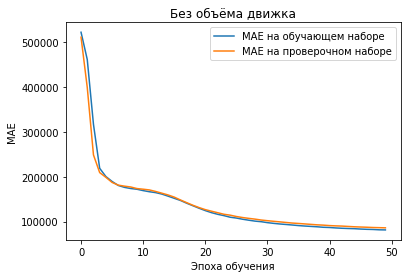

Валидационная выборка: MAE: 86087


In [0]:
plt.title('Без объёма движка')
plt.plot(history8.history['mean_absolute_error'][visible:], label='MAE на обучающем наборе')
plt.plot(history8.history['val_mean_absolute_error'][visible:], label='MAE на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MAE')
plt.legend()
plt.show()
print('Валидационная выборка: MAE: {:.0f}'.format(history8.history['val_mean_absolute_error'][-1]))

**Без мощности движка**

In [0]:
print('Старт')

x = []
y = []

for _id, car in enumerate(np.array(cars)):
  y.append(prices[_id])
  x_tr = to_ohe(car[0], marks_dict) + to_ohe(car[1], models_dict) + to_ohe(car[5], bodies_dict) + to_ohe(car[6], kpps_dict) + to_ohe(car[7], fuels_dict) + [years[_id]] + [mileages[_id]] + [volumes[_id]]
  x.append(x_tr)

print('X, Y собраны')
history9 = train(x, y)

Старт
X, Y собраны
Получены обучающая и валидационная выборки
Обучение модели...
Train on 56095 samples, validate on 14024 samples
Epoch 1/50
56095/56095 [==============================] - 4s 79us/sample - loss: 647880385225.3955 - mean_absolute_error: 520742.2500 - val_loss: 680046098082.6833 - val_mean_absolute_error: 504337.0938
Epoch 2/50
56095/56095 [==============================] - 4s 74us/sample - loss: 551187845186.0822 - mean_absolute_error: 441403.7188 - val_loss: 515719420400.5202 - val_mean_absolute_error: 365120.1250
Epoch 3/50
56095/56095 [==============================] - 4s 75us/sample - loss: 366423252242.0950 - mean_absolute_error: 282224.7500 - val_loss: 342331322334.1198 - val_mean_absolute_error: 227914.5469
Epoch 4/50
56095/56095 [==============================] - 4s 74us/sample - loss: 249038188701.3559 - mean_absolute_error: 212372.2812 - val_loss: 272680458873.7935 - val_mean_absolute_error: 208997.4062
Epoch 5/50
56095/56095 [==============================] -

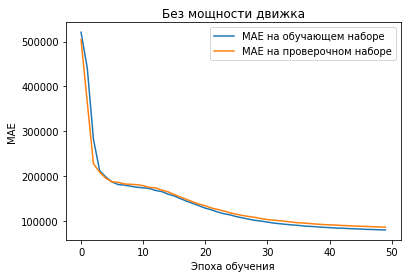

Валидационная выборка: MAE: 86704


In [0]:
plt.title('Без мощности движка')
plt.plot(history9.history['mean_absolute_error'][visible:], label='MAE на обучающем наборе')
plt.plot(history9.history['val_mean_absolute_error'][visible:], label='MAE на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MAE')
plt.legend()
plt.show()
print('Валидационная выборка: MAE: {:.0f}'.format(history9.history['val_mean_absolute_error'][-1]))

**Без объёма и мощности движка**

In [0]:
print('Старт')

x = []
y = []

for _id, car in enumerate(np.array(cars)):
  y.append(prices[_id])
  x_tr = to_ohe(car[0], marks_dict) + to_ohe(car[1], models_dict) + to_ohe(car[5], bodies_dict) + to_ohe(car[6], kpps_dict) + to_ohe(car[7], fuels_dict) + [years[_id]] + [mileages[_id]]
  x.append(x_tr)

print('X, Y собраны')
historya = train(x, y)

Старт
X, Y собраны
Получены обучающая и валидационная выборки
Обучение модели...
Train on 56095 samples, validate on 14024 samples
Epoch 1/50
56095/56095 [==============================] - 4s 80us/sample - loss: 648716330123.1925 - mean_absolute_error: 521074.5938 - val_loss: 682712938786.9025 - val_mean_absolute_error: 504974.6875
Epoch 2/50
56095/56095 [==============================] - 4s 72us/sample - loss: 559107706192.5262 - mean_absolute_error: 442841.8125 - val_loss: 529963149983.7626 - val_mean_absolute_error: 369096.1562
Epoch 3/50
56095/56095 [==============================] - 4s 74us/sample - loss: 391510958507.1611 - mean_absolute_error: 295171.5938 - val_loss: 377234307336.0319 - val_mean_absolute_error: 251662.0625
Epoch 4/50
56095/56095 [==============================] - 4s 73us/sample - loss: 288024929458.6227 - mean_absolute_error: 239036.4688 - val_loss: 312069881028.8557 - val_mean_absolute_error: 234870.1406
Epoch 5/50
56095/56095 [==============================] -

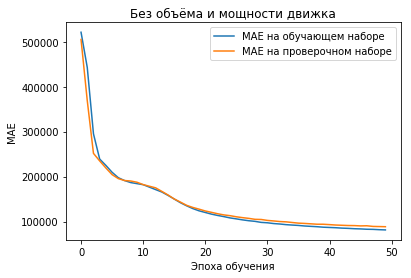

Валидационная выборка: MAE: 88558


In [0]:
plt.title('Без объёма и мощности движка')
plt.plot(historya.history['mean_absolute_error'][visible:], label='MAE на обучающем наборе')
plt.plot(historya.history['val_mean_absolute_error'][visible:], label='MAE на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MAE')
plt.legend()
plt.show()
print('Валидационная выборка: MAE: {:.0f}'.format(historya.history['val_mean_absolute_error'][-1]))

**Без марки**

In [0]:
print('Старт')

x = []
y = []

for _id, car in enumerate(np.array(cars)):
  y.append(prices[_id])
  x_tr = to_ohe(car[1], models_dict) + to_ohe(car[5], bodies_dict) + to_ohe(car[6], kpps_dict) + to_ohe(car[7], fuels_dict) + [years[_id]] + [mileages[_id]] + [volumes[_id]] + [powers[_id]]
  x.append(x_tr)

print('X, Y собраны')
historyb = train(x, y)

Старт
X, Y собраны
Получены обучающая и валидационная выборки
Обучение модели...
Train on 56095 samples, validate on 14024 samples
Epoch 1/50
56095/56095 [==============================] - 4s 78us/sample - loss: 649119525417.6665 - mean_absolute_error: 522435.5312 - val_loss: 685357749184.3286 - val_mean_absolute_error: 511240.6875
Epoch 2/50
56095/56095 [==============================] - 4s 72us/sample - loss: 567554807885.2175 - mean_absolute_error: 463652.7812 - val_loss: 541605769952.0182 - val_mean_absolute_error: 404193.6875
Epoch 3/50
56095/56095 [==============================] - 4s 73us/sample - loss: 389698096886.5760 - mean_absolute_error: 319883.1875 - val_loss: 353449822932.3354 - val_mean_absolute_error: 246501.9531
Epoch 4/50
56095/56095 [==============================] - 4s 73us/sample - loss: 246117257074.7083 - mean_absolute_error: 209608.5781 - val_loss: 259589548284.9333 - val_mean_absolute_error: 200331.6250
Epoch 5/50
56095/56095 [==============================] -

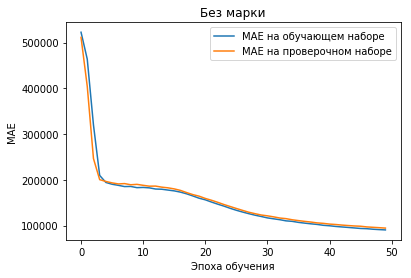

Валидационная выборка: MAE: 94517


In [0]:
plt.title('Без марки')
plt.plot(historyb.history['mean_absolute_error'][visible:], label='MAE на обучающем наборе')
plt.plot(historyb.history['val_mean_absolute_error'][visible:], label='MAE на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MAE')
plt.legend()
plt.show()
print('Валидационная выборка: MAE: {:.0f}'.format(historyb.history['val_mean_absolute_error'][-1]))

**Без модели**

In [0]:
print('Старт')

x = []
y = []

for _id, car in enumerate(np.array(cars)):
  y.append(prices[_id])
  x_tr = to_ohe(car[0], marks_dict) + to_ohe(car[5], bodies_dict) + to_ohe(car[6], kpps_dict) + to_ohe(car[7], fuels_dict) + [years[_id]] + [mileages[_id]] + [volumes[_id]] + [powers[_id]]
  x.append(x_tr)

print('X, Y собраны')
historyc = train(x, y)

Старт
X, Y собраны
Получены обучающая и валидационная выборки
Обучение модели...
Train on 56095 samples, validate on 14024 samples
Epoch 1/50
56095/56095 [==============================] - 3s 46us/sample - loss: 647517352221.8694 - mean_absolute_error: 521243.5000 - val_loss: 679126044080.8489 - val_mean_absolute_error: 506369.0312
Epoch 2/50
56095/56095 [==============================] - 2s 39us/sample - loss: 550530305140.0089 - mean_absolute_error: 449230.2812 - val_loss: 512782454319.0234 - val_mean_absolute_error: 377582.2500
Epoch 3/50
56095/56095 [==============================] - 2s 39us/sample - loss: 357215574744.5469 - mean_absolute_error: 289002.9688 - val_loss: 324310021159.1375 - val_mean_absolute_error: 221850.0000
Epoch 4/50
56095/56095 [==============================] - 2s 40us/sample - loss: 229365954020.5722 - mean_absolute_error: 199778.2969 - val_loss: 250772007567.9909 - val_mean_absolute_error: 198266.7031
Epoch 5/50
56095/56095 [==============================] -

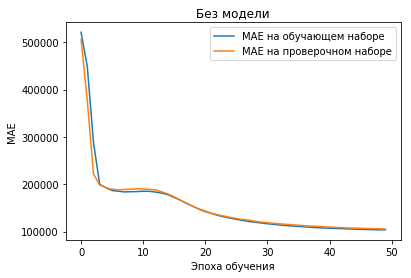

Валидационная выборка: MAE: 105201


In [0]:
plt.title('Без модели')
plt.plot(historyc.history['mean_absolute_error'][visible:], label='MAE на обучающем наборе')
plt.plot(historyc.history['val_mean_absolute_error'][visible:], label='MAE на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MAE')
plt.legend()
plt.show()
print('Валидационная выборка: MAE: {:.0f}'.format(historyc.history['val_mean_absolute_error'][-1]))

**Без нормализации**

In [0]:
print('Старт')

x = []
y = []

for _id, car in enumerate(np.array(cars)):
  y.append(prices[_id])
  x_tr = to_ohe(car[0], marks_dict) + to_ohe(car[5], bodies_dict) + to_ohe(car[6], kpps_dict) + to_ohe(car[7], fuels_dict) + [years_raw[_id]] + [mileages_raw[_id]] + [volumes_raw[_id]] + [powers_raw[_id]]
  x.append(x_tr)

print('X, Y собраны')
historyd = train(x, y)

Старт
X, Y собраны
Получены обучающая и валидационная выборки
Обучение модели...
Train on 56095 samples, validate on 14024 samples
Epoch 1/50
56095/56095 [==============================] - 3s 47us/sample - loss: 463631378844.0096 - mean_absolute_error: 371080.2500 - val_loss: 349879718140.3491 - val_mean_absolute_error: 282724.0312
Epoch 2/50
56095/56095 [==============================] - 2s 41us/sample - loss: 268521473540.7006 - mean_absolute_error: 272700.1250 - val_loss: 297294898789.9327 - val_mean_absolute_error: 269177.7812
Epoch 3/50
56095/56095 [==============================] - 2s 41us/sample - loss: 247036270666.2968 - mean_absolute_error: 267211.7500 - val_loss: 279282999010.9390 - val_mean_absolute_error: 268744.7812
Epoch 4/50
56095/56095 [==============================] - 2s 40us/sample - loss: 230685157167.3482 - mean_absolute_error: 257646.6562 - val_loss: 261720875416.8990 - val_mean_absolute_error: 247433.2188
Epoch 5/50
56095/56095 [==============================] -

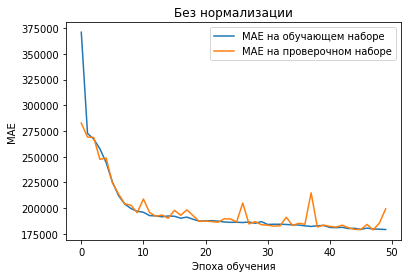

Валидационная выборка: MAE: 199305


In [0]:
plt.title('Без нормализации')
plt.plot(historyd.history['mean_absolute_error'][visible:], label='MAE на обучающем наборе')
plt.plot(historyd.history['val_mean_absolute_error'][visible:], label='MAE на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('MAE')
plt.legend()
plt.show()
print('Валидационная выборка: MAE: {:.0f}'.format(historyd.history['val_mean_absolute_error'][-1]))